## 02 - Baseline Models
German Credit Risk Dataset

Bu notebook'ta tüm modeller varsayılan parametrelerle eğitilir. Amaç, feature engineering veya hiperparametre optimizasyonu öncesinde bir referans nokta oluşturmaktır.

### Setup

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

import mlflow
import mlflow.sklearn

import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('mlflow').setLevel(logging.ERROR)

sns.set_theme(style='whitegrid')
COLORS = {'good': '#4a90a4', 'bad': '#e07b54'}
RANDOM_STATE = 42

mlflow.set_tracking_uri('file:../mlruns')
mlflow.set_experiment('credit_risk_baseline')

<Experiment: artifact_location='file:///c:/Users/enesm/OneDrive/Masaüstü/Turkish-AI-Community/hsd_agu_egitim/notebooks/../mlruns/277724166436677784', creation_time=1770669188977, experiment_id='277724166436677784', last_update_time=1770669188977, lifecycle_stage='active', name='credit_risk_baseline', tags={}>

### Load Data

In [26]:
df = pd.read_csv('../data/german_credit_data.csv', index_col=0)

job_mapping = {0: 'unskilled_non_resident', 1: 'unskilled_resident', 2: 'skilled', 3: 'highly_skilled'}
df['Job'] = df['Job'].map(job_mapping)

print(f"Shape: {df.shape}")
print(f"\nTarget distribution:\n{df['Risk'].value_counts()}")

Shape: (1000, 10)

Target distribution:
Risk
good    700
bad     300
Name: count, dtype: int64


### Define Features & Split

Data leak'i önlemek için split, herhangi bir preprocessing adımından **önce** yapılır.

In [27]:
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

X = df[num_features + cat_features]
y = df['Risk'].map({'good': 0, 'bad': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 9), Test: (200, 9)


### Helper Functions

Her model için `create_pipeline` fonksiyonu aşağıdaki adımları tek bir `sklearn.Pipeline` içinde birleştirir:

```
Ham Veri
  │
  ├─ Sayısal değişkenler (Age, Credit amount, Duration)
  │    ├─ SimpleImputer(median)  → Eksik değerler medyan ile doldurulur
  │    └─ StandardScaler()       → Ortalama=0, Std=1 olacak şekilde ölçeklenir
  │
  ├─ Kategorik değişkenler (Sex, Job, Housing, Saving accounts, Checking account, Purpose)
  │    ├─ SimpleImputer('missing') → Eksik değerler 'missing' etiketi ile doldurulur
  │    └─ OneHotEncoder()          → Her kategori ayrı bir binary sütuna dönüştürülür
  │
  └─ Classifier (model)  → Ön işlemden geçen veri modele beslenir
```

**Neden Pipeline?** Tüm ön işleme adımları ve model tek bir objede toplandığı için:
- **Data leak önlenir:** `fit` yalnızca eğitim verisinde çalışır, test verisi dönüşüme sadece `transform` ile uğrar.
- **Cross-validation güvenilir olur:** Her fold'da ön işleme sıfırdan yapılır.
- **Tekrarlanabilirlik sağlanır:** Pipeline kaydedilip yüklendikten sonra aynı dönüşümler otomatik uygulanır.

Her pipeline kendi preprocessor'üne sahip olmalıdır. Paylaşılan preprocessor, fit sırasında diğer pipeline'ları etkiler ve hatalı sonuç üretir.

In [28]:
def create_pipeline(model):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ])
    return Pipeline([('preprocessor', preprocessor), ('classifier', model)])

def evaluate(pipeline, X_train, X_test, y_train, y_test):
    cv_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Test AUC': roc_auc_score(y_test, y_prob),
        'CV AUC (5-fold)': cv_auc
    }, y_pred, y_prob

### Train All Models

Önce Logistic Regression baseline olarak çalışır, ardından tree-based modeller döngüde eğitilir.

In [29]:
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, verbosity=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
}

results = {}
predictions = {}
probabilities = {}
pipelines = {}

for name, model in models.items():
    pipeline = create_pipeline(model)
    metrics, y_pred, y_prob = evaluate(pipeline, X_train, X_test, y_train, y_test)
    
    results[name] = metrics
    predictions[name] = y_pred
    probabilities[name] = y_prob
    pipelines[name] = pipeline
    
    # MLflow logging
    with mlflow.start_run(run_name=name):
        mlflow.set_tag('stage', 'baseline')
        mlflow.set_tag('model_type', name)
        mlflow.log_param('random_state', RANDOM_STATE)
        mlflow.log_param('num_features', num_features)
        mlflow.log_param('cat_features', cat_features)
        mlflow.log_metrics({
            'accuracy': metrics['Accuracy'],
            'precision': metrics['Precision'],
            'recall': metrics['Recall'],
            'f1': metrics['F1'],
            'test_auc': metrics['Test AUC'],
            'cv_auc_5fold': metrics['CV AUC (5-fold)'],
        })
        mlflow.sklearn.log_model(pipeline, name='model')
    
    print(f"{name}: CV AUC={metrics['CV AUC (5-fold)']:.4f}, Test AUC={metrics['Test AUC']:.4f}")

print("\nAll models trained & logged to MLflow!")

Logistic Regression: CV AUC=0.7481, Test AUC=0.7613
Decision Tree: CV AUC=0.5911, Test AUC=0.5917
Random Forest: CV AUC=0.7260, Test AUC=0.7520
XGBoost: CV AUC=0.7202, Test AUC=0.7586
LightGBM: CV AUC=0.7299, Test AUC=0.7582
CatBoost: CV AUC=0.7430, Test AUC=0.7923

All models trained & logged to MLflow!


### Metrik Açıklamaları

| Metrik | Açıklama | Bu problem için önemi |
|--------|----------|----------------------|
| **Accuracy** | Doğru tahmin edilen örneklerin oranı | Dengesiz veri setlerinde yanıltıcı olabilir. 'good' sınıfı baskın olduğu için yüksek accuracy düşük performansı maskeleyebilir. |
| **Precision** | 'bad' olarak tahmin edilenlerin gerçekten 'bad' olma oranı | Yüksek precision, gereksiz kredi ret oranını azaltır. Banka gereksiz yere müşteri kaybetmez. |
| **Recall** | Gerçek 'bad' müşterilerin ne kadarının yakalandığı | Kredi riskinde en kritik metrik. Düşük recall, riskli müşterilere kredi verilmesi anlamına gelir ve doğrudan mali kayba yol açar. |
| **F1** | Precision ve Recall'un harmonik ortalaması | İkisi arasındaki dengeyi gösterir. Tek bir skor ile model karşılaştırması yapmak için kullanışlıdır. |
| **Test AUC** | Test seti üzerinde sınıfları ayırt edebilme gücü (0.5 = rastgele, 1.0 = mükemmel) | Threshold'dan bağımsız genel performansı ölçer. Tek split'e bağlı olduğu için varyansı yüksektir. |
| **CV AUC** | 5-fold cross-validation ile eğitim seti üzerinde hesaplanan ortalama AUC | Modelin genelleme yeteneğini daha güvenilir ölçer. Model seçiminde birincil metrik olarak kullanılır. |

**Bu problem için:** Kredi riski asimetrik bir problemdir. Riskli bir müşteriyi kaçırmak (False Negative), iyi bir müşteriyi reddetmekten (False Positive) çok daha maliyetlidir. Bu yüzden **Recall** öncelikli metriğimizdir. Ancak baseline aşamasında model seçimi için **CV AUC** kullanılır, çünkü threshold'dan bağımsız ve güvenilir bir karşılaştırma sağlar. Recall optimizasyonu, feature engineering aşamasında threshold ayarıyla yapılacaktır.

### Results Comparison

Model seçimi **CV AUC**'ye göre yapılır. Test AUC tek bir split'e bağlıdır ve şansa göre değişebilir, CV ise daha güvenilir bir tahmindir.

**Overfitting kontrolü:** Test AUC ile CV AUC arasındaki fark modelin genelleme durumunu gösterir.
- Fark küçükse: model kararlı, güvenilir

In [30]:
results_df = pd.DataFrame(results).T.round(4)
results_df.sort_values('CV AUC (5-fold)', ascending=False)

,Accuracy,Precision,Recall,F1,Test AUC,CV AUC (5-fold)
Logistic Regression,0.740,0.6053,0.3833,0.4694,0.7613,0.7481
CatBoost,0.770,0.6522,0.5000,0.5660,0.7923,0.7430
LightGBM,0.750,0.6042,0.4833,0.5370,0.7582,0.7299
Random Forest,0.730,0.5750,0.3833,0.4600,0.7520,0.7260
XGBoost,0.765,0.6383,0.5000,0.5607,0.7586,0.7202
Decision Tree,0.655,0.4262,0.4333,0.4298,0.5917,0.5911


### Model Inspection

In [31]:
# Select model to inspect
SELECTED_MODEL = 'Random Forest'

print(f"Model: {SELECTED_MODEL}")
print(f"Test AUC: {results_df.loc[SELECTED_MODEL, 'Test AUC']:.4f}")
print(f"CV AUC (5-fold): {results_df.loc[SELECTED_MODEL, 'CV AUC (5-fold)']:.4f}")
print(f"\n{'='*50}")
print("Classification Report:")
print(classification_report(y_test, predictions[SELECTED_MODEL], target_names=['good', 'bad']))

Model: Random Forest
Test AUC: 0.7520
CV AUC (5-fold): 0.7260

Classification Report:
              precision    recall  f1-score   support

        good       0.77      0.88      0.82       140
         bad       0.57      0.38      0.46        60

    accuracy                           0.73       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.71      0.73      0.71       200



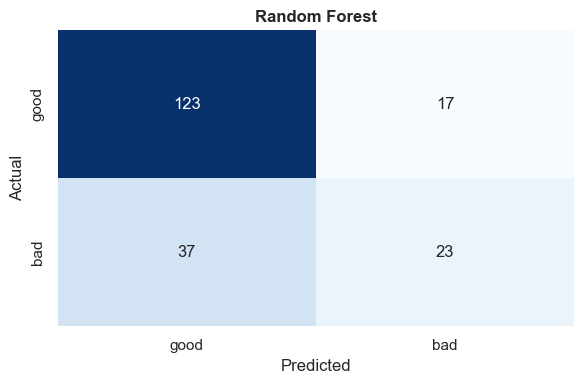

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(y_test, predictions[SELECTED_MODEL])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
            xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])
ax.set_title(f'{SELECTED_MODEL}', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()